Group Members: Dhruv, Rohan, Sarthak, Uday

In [6]:
# !pip install yahoofinance
# !pip install hmmlearn
# !pip install seaborn

Defaulting to user installation because normal site-packages is not writeable


In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
sys.path.append(os.getcwd() + '/modules')
import seaborn as sns

from modules.directional_change import get_data, get_DC_data, get_DC_data_v2, get_TMV, get_T, get_R
from modules.hidden_markov_model import fit_hmm
from modules.cross_validation import Pipeline, CustomCrossValidation

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn')
sns.set_theme()

In [10]:
"""Hyperparameters"""

TYPE = 'equity' # 'equity' or 'fx' or 'bond'

TICKER_MAPPER = {'equity':['^DJI','^GSPC'],
                'bond':['^TNX', '^IRX'],
                'fx':['RUB=X','GBP=X']}

TICKERS = TICKER_MAPPER[TYPE]
START_DATE = "2005-01-01"
TRAIN_END = "2017-12-31"
VALID_START = "2018-01-01"
VALID_END = "2019-12-31"
TEST_START = "2020-01-01"

THETA = 0.025
NUM_REGIMES = 2

TRADING_DAY = {'equity':6.5, 'fx':12,'bond':9} # number of hours in a day we offset

In [ ]:
pipeline = Pipeline(theta=0.025, type_mapper = {'equity':['^GSPC']}, strat = "control" )
pipeline.fit(plot=False, verbose=False)

In [ ]:
pipeline.trading_metrics

In [ ]:
pipeline = Pipeline(theta=0.025, type_mapper = {'equity':['^GSPC']} )
pipeline.fit(plot=False, verbose=False)
pipeline.trading_metrics

# Experiments

Put self-contained code here for different experiments run. Easier to put in the report that way.

## Plotting data

[*********************100%***********************]  3 of 3 completed


,^DJI,^GSPC,^IXIC
count,9061.000000,9061.000000,9061.000000
mean,0.000209,0.000219,0.000278
std,0.012987,0.013515,0.014427
min,-0.138348,-0.124082,-0.140664
25%,-0.005315,-0.005447,-0.006284
50%,0.000128,0.000115,0.000094
75%,0.005850,0.006119,0.007205
max,0.117979,0.126971,0.159344


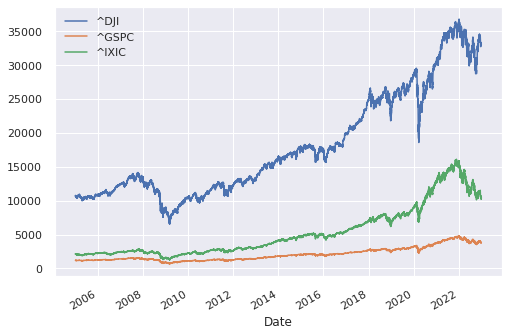

In [7]:
df_ts = get_data(TICKERS, START_DATE, TRADING_DAY[TYPE]/2)
df_ret = df_ts.pct_change().dropna()

DC = {}

for ticker in TICKERS:
    DC[ticker] = get_DC_data(df_ts[ticker], THETA)

tmv = {}
T = {}
R = {}
for ticker in TICKERS:
    tmv[ticker] = get_TMV(DC[ticker],THETA)
    T[ticker] = get_T(DC[ticker])
    R[ticker] = get_R(tmv[ticker],T[ticker],THETA)

df_ts.plot()
df_ret.describe()

## Visualizing DC indicators

[*********************100%***********************]  3 of 3 completed


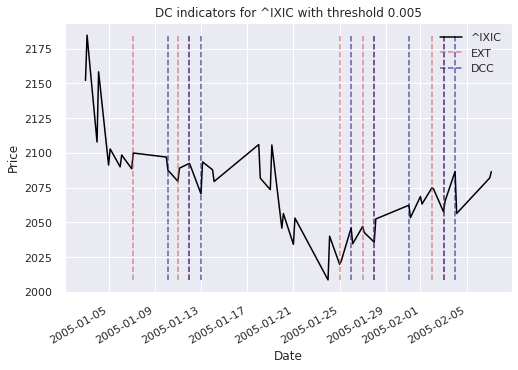

In [8]:
df_ts = get_data(TICKERS, START_DATE, TRADING_DAY[TYPE]/2)
df_ret = df_ts.pct_change().dropna()

DC = {}
for ticker in TICKERS:
    DC[ticker] = get_DC_data(df_ts[ticker], THETA)

# example
sample_ts = df_ts[TEST_TICKER][:50]
last_date = sample_ts.index[-1]

dcc = []
dcc_idx = []
ext = []
ext_idx = []

for i in range(len(DC[TEST_TICKER])):
    dcc.append(DC[TEST_TICKER][i][1])
    dcc_idx.append(DC[TEST_TICKER][i][0])
    ext.append( DC[TEST_TICKER][i][3] )
    ext_idx.append( DC[TEST_TICKER][i][2] )
    
dcc = pd.Series( data=dcc, index = dcc_idx)
ext = pd.Series( data=ext, index = ext_idx)

sample_dcc = dcc.loc[:last_date].index
sample_ext = ext.loc[:last_date].index

fig,ax = plt.subplots()
sample_ts.plot(ax=ax, color ='black')
ymin, ymax = sample_ts.min(), sample_ts.max()
ax.vlines(sample_ext, ymin, ymax, 'r','dashed',label='EXT',alpha=0.6)
ax.vlines(sample_dcc, ymin, ymax, 'navy','dashed',label='DCC',alpha=0.6)
ax.set_title(f"DC indicators for {TEST_TICKER} with threshold {THETA}")
ax.set_ylabel("Price")
ax.legend()
plt.show()

## New version of DC indicators where we allow opposite direction movements

[*********************100%***********************]  3 of 3 completed


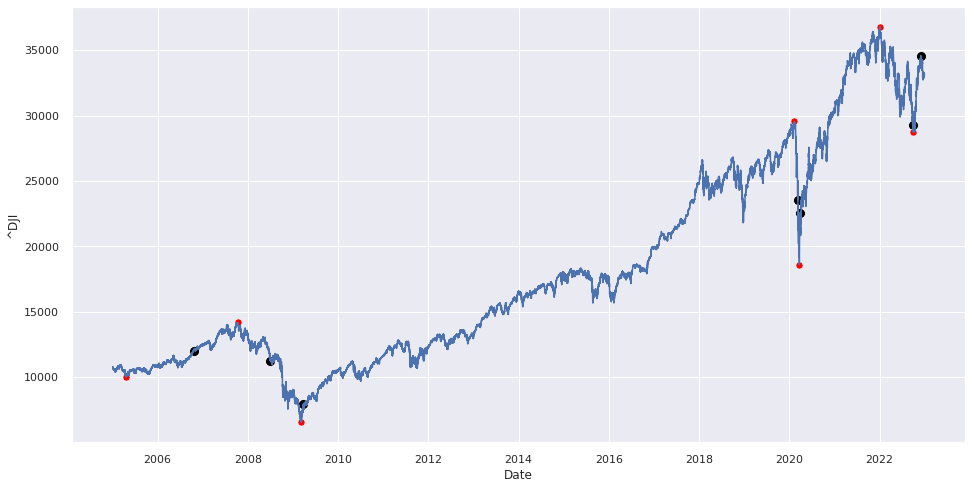

In [9]:
df_ts = get_data(TICKERS, START_DATE, TRADING_DAY[TYPE]/2)
df_ret = df_ts.pct_change().dropna()

features = get_DC_data_v2(df_ts[TICKERS[0]], 0.2)
fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(data=df_ts[TICKERS[0]])
sns.scatterplot(x = [i[0] for i in features], y = [i[1] for i in features], color='black', s=100)
sns.scatterplot(x = [i[2] for i in features], y = [i[3] for i in features], color='red', s=50)
None

# Pipeline With Cross-Validation

In [13]:
parameter_grid = {
    'theta': [0.25, 0.0025]
}

In [15]:
trading_day = {'equity':6.5, 'fx':12,'bond':9}
df_ts = get_data('^GSPC', start_date='2005-01-01', delta=trading_day['equity'])
cv = CustomCrossValidation(pipeline_class=Pipeline, parameter_grid=parameter_grid, verbose=True)
cv.fit(data = df_ts, metric='sharpe', minimize=False)

[*********************100%***********************]  1 of 1 completed
Iteration: 0: Parameters: {'theta': 0.25}


TypeError: Cannot divide float64 data by TimedeltaArray